In [1]:
from mle import negative_log_lik, CGMY
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
np.set_printoptions(precision=4, suppress=False)

In [3]:
DATA_FOLDER = "../data"

In [4]:
def load_returns(path, start_date=None, end_date=None):
    df = pd.read_csv(f"{DATA_FOLDER}/{path}")
    df["Date"] = pd.to_datetime(df["Date"])
    df.index = df["Date"]
    col = "Close" if "Last Price" not in df.columns else "Last Price"
    df = df.filter([col])
    df = df.sort_index()
    if start_date is not None and end_date is not None:
        df = df[(df.index >= start_date) & (df.index <= end_date)]
    rets = np.log(df[col]).diff().dropna()
    return rets

In [10]:
def optim_parall(data, seed=123):
    np.random.seed(seed)
    c = np.random.uniform(1e-5, 200)
    g = np.random.uniform(1, 200)
    m = np.random.uniform(1, 200)
    y = np.random.uniform(-5, 1.9)
    sigma = np.random.uniform(1e-5, 0.1)
    res = minimize(
        lambda x: negative_log_lik(x, data),
        x0=[c, g, m, y, sigma],
        bounds=[
            (1e-3, np.inf),
            (1, np.inf),
            (1, np.inf),
            (-5, 1.9),
            (1e-5, 0.1),
        ]
    )
    
    return res

In [6]:
start_date = pd.Timestamp("2021-07-01")
end_date = pd.Timestamp("2025-06-30")

SPX Index Daily

In [26]:
spx_rets_day = load_returns("SPX_D.csv", start_date=start_date, end_date=end_date)

In [27]:
master_seed = 42
rng = np.random.default_rng(master_seed)
seeds = rng.integers(0, 2**32, size=300)
results_spx_day = Parallel(n_jobs=-1)(
    delayed(optim_parall)(spx_rets_day, seed) for seed in seeds
)
mle_spx_day = np.array([np.concat([res.x, [res.fun]]) for res in results_spx_day])

/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(-0.5 * t * (self.sigma * u) ** 2)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res 

In [28]:
np.savetxt("../fits/spx_day.csv", mle_spx_day)

In [29]:
spx_day_best_fits = mle_spx_day[mle_spx_day[:, 5].argsort()]
spx_day_best_fits[:3]


array([[ 2.4364e-02,  9.1404e+01,  8.5719e+01,  6.9263e-01,  1.0000e-05,
        -3.1371e+03],
       [ 1.7452e-01,  1.1953e+02,  1.1346e+02,  3.5132e-01,  1.0000e-05,
        -3.1368e+03],
       [ 1.9700e-01,  1.2115e+02,  1.1551e+02,  3.3043e-01,  1.0000e-05,
        -3.1368e+03]])

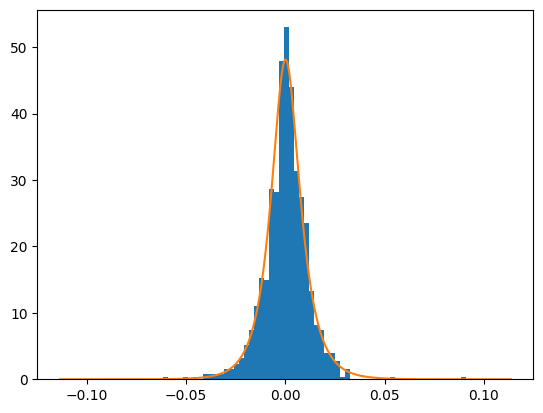

In [133]:
cgmy = CGMY(spx_rets_day, spx_day_best_fits[0][:-1], adjust_L=True)
cgmy2 = CGMY(spx_rets_day, spx_day_best_fits[1][:-1], adjust_L=True)
x, pdf = cgmy.compute_pdf_from_cf()
x2, pdf2 = cgmy.compute_pdf_from_cf()
plt.hist(spx_rets_day, density=True, bins=60)
plt.plot(x, pdf)
#plt.plot(x2, pdf2)

AAPL US Equity Daily

In [11]:
appl_rets_daily = load_returns("AAPL_D.csv", start_date=start_date, end_date=end_date)

In [15]:
master_seed = 42
rng = np.random.default_rng(master_seed)
seeds = rng.integers(0, 2**32, size=300)
results_aapl_day = Parallel(n_jobs=-1)(
    delayed(optim_parall)(appl_rets_daily, seed) for seed in seeds
)
mle_aapl_day = np.array([np.concat([res.x, [res.fun]]) for res in results_aapl_day])


/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(-0.5 * t * (self.sigma * u) ** 2)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res 

In [16]:
aapl_day_best_fits = mle_aapl_day[mle_aapl_day[:, 5].argsort()]
aapl_day_best_fits[:10]

array([[ 4.0552e-02,  6.0527e+01,  5.5630e+01,  6.5767e-01,  1.0000e-05,
        -2.6749e+03],
       [ 6.1248e-01,  8.3328e+01,  8.0555e+01,  1.1701e-01,  3.9506e-03,
        -2.6741e+03],
       [ 1.7720e+00,  9.1481e+01,  8.9144e+01, -1.0365e-01,  4.7207e-03,
        -2.6738e+03],
       [ 2.2413e+00,  9.1837e+01,  8.9588e+01, -1.6161e-01,  5.0899e-03,
        -2.6738e+03],
       [ 1.8935e+01,  1.1878e+02,  1.1529e+02, -5.4999e-01,  4.8257e-03,
        -2.6727e+03],
       [ 9.6970e+01,  1.2134e+02,  1.1929e+02, -9.5356e-01,  6.5630e-03,
        -2.6727e+03],
       [ 7.2126e+01,  1.1622e+02,  1.1239e+02, -9.1974e-01,  7.0099e-03,
        -2.6726e+03],
       [ 1.3370e+02,  1.2486e+02,  1.2276e+02, -1.0146e+00,  6.5648e-03,
        -2.6726e+03],
       [ 3.2219e+01,  9.4466e+01,  9.5671e+01, -8.8721e-01,  9.4124e-03,
        -2.6725e+03],
       [ 1.2803e+02,  1.1686e+02,  1.1544e+02, -1.0662e+00,  7.6589e-03,
        -2.6725e+03]])

In [25]:
np.savetxt("../fits/aapl_day.csv", aapl_day_best_fits)

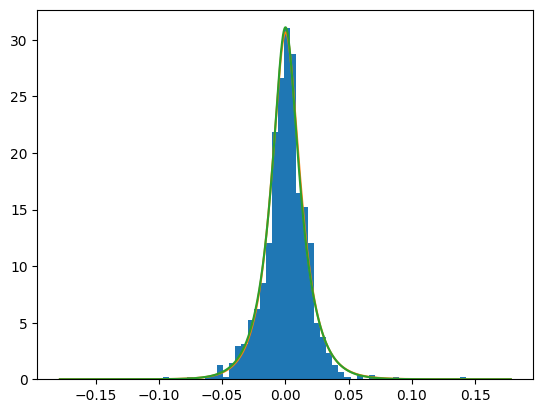

In [32]:
cgmy = CGMY(appl_rets_daily, aapl_day_best_fits[0][:-1], adjust_L=True)
cgmy2 = CGMY(appl_rets_daily, aapl_day_best_fits[1][:-1], adjust_L=True)
x, pdf = cgmy.compute_pdf_from_cf()
x2, pdf2 = cgmy2.compute_pdf_from_cf()
plt.hist(appl_rets_daily, density=True, bins=50)
plt.plot(x, pdf)
plt.plot(x2, pdf2)

AAPL Minute

In [ ]:
cgmy = CGMY([0], [10, 10, 15, -0.3, 0.01], adjust_L=True)

In [63]:
data = cgmy.sample(10**3)

In [64]:
cgmy = CGMY(data, [10, 10, 15, -0.3, 0.01], adjust_L=True)

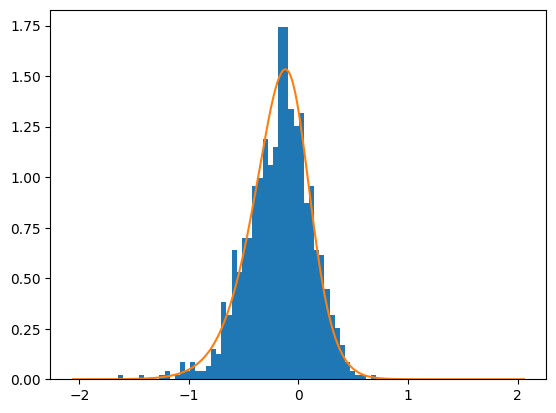

In [65]:
x, pdf = cgmy.compute_pdf_from_cf()
plt.hist(data, density=True, bins=50)
plt.plot(x, pdf)

In [76]:
master_seed = 42
rng = np.random.default_rng(master_seed)
seeds = rng.integers(0, 2**32, size=300)
results = Parallel(n_jobs=-1)(
    delayed(optim_parall)(data, seed) for seed in seeds
)
results

/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(-0.5 * t * (self.sigma * u) ** 2)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res 

[  message: ABNORMAL: 
   success: False
    status: 2
       fun: 13932.45935776141
         x: [ 1.448e+02  1.636e+02  1.181e+02 -2.193e+00  8.596e-02]
       nit: 0
       jac: [ 3.185e+06 -1.120e+06  2.029e+06  1.895e+06  6.100e+06]
      nfev: 102
      njev: 17
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
   success: True
    status: 0
       fun: 193215.02050650952
         x: [ 2.300e+00  1.864e+02  9.238e+01 -1.375e+00  1.814e-02]
       nit: 4
       jac: [ 1.311e+11  1.594e+08  6.568e+10  6.540e+10  1.309e+11]
      nfev: 222
      njev: 37
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
   success: True
    status: 0
       fun: 350.519982993145
         x: [ 8.157e+01  1.311e+02  6.741e+01 -5.000e+00  3.436e-01]
       nit: 29
       jac: [-9.152e-04  0.000e+00  0.000e+00  8.583e-04  5.198e-02]
      nfev: 228
      njev: 

In [77]:
lks = np.array([res.fun for res in results])
params = np.array([res.x for res in results])
mle = params[lks == np.min(lks)]

In [88]:
params[lks < 173]

array([[3.61674e-01, 3.99907e+00, 2.50402e+03, 3.05826e-01, 2.34019e-01],
       [2.75454e-01, 3.72317e+00, 6.91995e+01, 4.64334e-01, 2.30875e-01],
       [3.48123e-01, 3.95660e+00, 6.40593e+02, 3.25594e-01, 2.33827e-01],
       [3.50400e-01, 3.96387e+00, 7.27530e+02, 3.22405e-01, 2.33850e-01]])

In [78]:
mle

array([[ 0.27545,  3.72317, 69.19947,  0.46433,  0.23088]])

In [79]:
cgmy2 = CGMY(data, [ 0.27545,  3.72317, 69.19947,  0.46433,  0.23088], adjust_L=True)

In [ ]:
cgmy.log_lik()

np.float64(-175.72545335428572)

In [81]:
cgmy2.log_lik()

np.float64(-172.70536497706428)

In [72]:
negative_log_lik([10, 10, 15, -0.3, 0.01], data)

np.float64(175.72545335428572)

In [82]:
res = minimize(
        lambda x: negative_log_lik(x, data),
        x0=[10, 10, 10, -0.3, 0.01],
        bounds=[
            (1e-3, np.inf),
            (1, np.inf),
            (1, np.inf),
            (-5, 1.9),
            (1e-6, 2),
        ]
       
    )

In [84]:
res.fun

np.float64(172.71854225328002)

In [83]:
res.x

array([3.41972e-01, 3.94144e+00, 3.63609e+02, 3.38119e-01, 2.33548e-01])

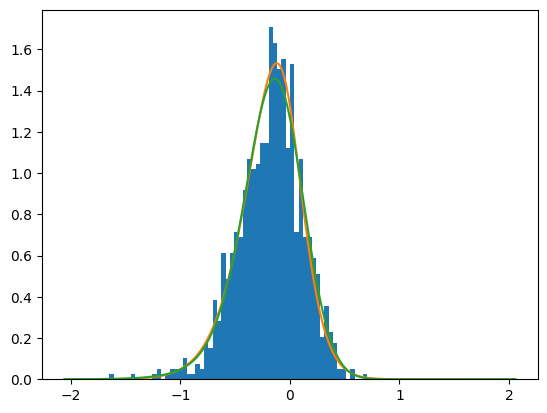

In [73]:
x, pdf = cgmy.compute_pdf_from_cf()
x2, pdf2 = cgmy2.compute_pdf_from_cf()
plt.hist(data, density=True, bins=60)
plt.plot(x, pdf)
plt.plot(x2, pdf2)

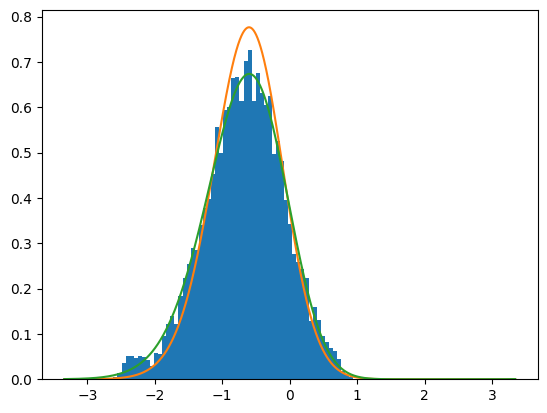

In [48]:
cgmy.log_lik()

np.float64(4017.06816401965)

In [49]:
cgmy2.log_lik()

np.float64(3425.905788191628)

In [25]:
ix = likelihoods < -489
params[ix]

array([[ 7.31320e+01,  2.07427e+01,  2.23326e+01, -1.14701e+00,
         3.50833e-02],
       [ 3.19494e+02,  2.52595e+01,  2.67851e+01, -1.52274e+00,
         8.29770e-03],
       [ 6.71281e+01,  2.05458e+01,  2.21411e+01, -1.12001e+00,
         3.52476e-02],
       [ 3.97157e+02,  2.40032e+01,  2.56610e+01, -1.75380e+00,
         4.68377e-02],
       [ 8.93964e+02,  2.55839e+01,  2.72656e+01, -2.04455e+00,
         5.03849e-02],
       [ 2.88497e+01,  1.89768e+01,  2.04864e+01, -8.02953e-01,
         3.91874e-03],
       [ 9.41687e+00,  1.64486e+01,  1.79564e+01, -4.49549e-01,
         2.57148e-03],
       [ 2.40829e+01,  1.85315e+01,  2.00403e+01, -7.47943e-01,
         3.61847e-03],
       [ 1.88674e+02,  2.25274e+01,  2.41596e+01, -1.49029e+00,
         4.30655e-02],
       [ 1.18931e+02,  2.15351e+01,  2.32064e+01, -1.33557e+00,
         4.40997e-02],
       [ 1.22797e+02,  2.17034e+01,  2.33186e+01, -1.33604e+00,
         4.00958e-02],
       [ 7.58045e+01,  2.08372e+01,  2.2426

In [57]:
data = spx_rets_day.values
res = minimize(
    lambda x: negative_log_lik(x, data),
    x0=[10, 10, 10, 10**-3, 0.001],
    bounds=[
        (1e-3, np.inf),
        (1, np.inf),
        (1, np.inf),
        (1e-3, 1),
        (0, 1),
    ],
    method="Nelder-Mead",
)

res2 = minimize(
    lambda x: negative_log_lik(x, data),
    x0=[100, 100, 100, 0.1, 0.001],
    bounds=[
        (10 ** (-3), np.inf),
        (1, np.inf),
        (1, np.inf),
        (1e-3, 1),
        (0, 1),
    ],
    method="Nelder-Mead",
)

res3 = minimize(
    lambda x: negative_log_lik(x, data),
    x0=[3, 3, 3, 10**-3, 0.001],
    bounds=[
        (10 ** (-3), np.inf),
        (1, np.inf),
        (1, np.inf),
        (1e-3, 1),
        (0, 1),
    ],
    method="Nelder-Mead",
)

In [58]:
res.x

array([9.63e-03, 7.79e+01, 7.02e+01, 8.38e-01, 8.43e-04])

In [59]:
res2.x

array([3.53e-01, 1.28e+02, 1.20e+02, 2.10e-01, 6.69e-04])

In [60]:
res3.x

array([2.92e-01, 9.37e+01, 8.78e+01, 3.90e-02, 6.20e-03])

In [30]:
res.fun

np.float64(-3960.8749140176997)

In [9]:
res2.fun

np.float64(-3943.194596994979)

In [23]:
res3.fun

np.float64(-3933.038606902148)

In [10]:
cgmy_fitted2 = CGMY(data, [7.789711845562872,
 67.17959263000856,
 94.95981317068947,
 1.8695502184542019,
 0.0006538602842829902], adjust_L=True)
x2, pdf2 = cgmy_fitted2.compute_pdf_from_cf()

In [11]:
cgmy_fitted2.L

np.float64(1235.5468529079014)

In [12]:
cgmy_fitted2.L

np.float64(1235.5468529079014)

In [13]:
l = cgmy_fitted2.L
n = cgmy_fitted2.N

In [14]:
(-0.003607	 + l/2) * n / l

np.float64(131071.234708578)

In [15]:
x2[131071]

np.float64(-0.004713237201372067)

In [16]:
cgmy_fitted2.density.assign(val= lambda u: x2[u["interval"]])

,rets,interval,val
0,0.008278,131073,0.004713
1,0.018785,131075,0.014140
2,-0.003607,131071,-0.004713
3,0.000594,131072,0.000000
4,-0.005665,131070,-0.009426
...,...,...,...
1249,0.000074,131072,0.000000
1250,-0.005291,131070,-0.009426
1251,0.010228,131074,0.009426
1252,0.000920,131072,0.000000


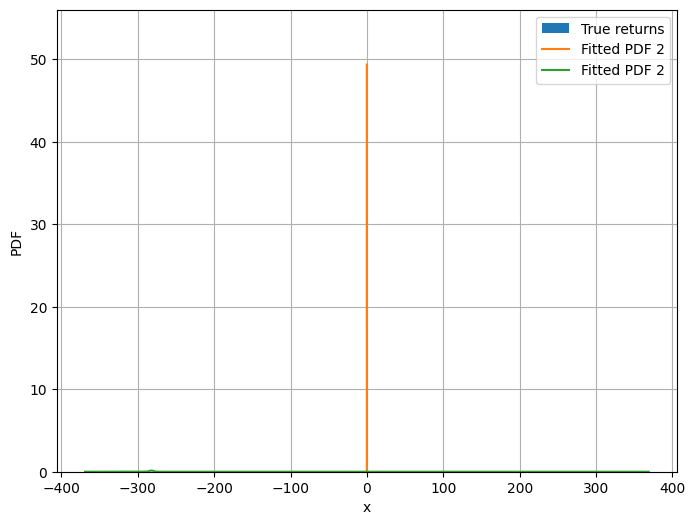

In [30]:
cgmy_fitted = CGMY(data, res["x"], adjust_L=True)
cgmy_fitted2 = CGMY(data, res2["x"], adjust_L=True)
cgmy_fitted3 = CGMY(data, [14.1532802074954,
 286.4927601113419,
 147.23849233959862,
 1.5847657376972388,
 0.0016680027130499104], adjust_L=True)



x, pdf = cgmy_fitted.compute_pdf_from_cf()
x2, pdf2 = cgmy_fitted2.compute_pdf_from_cf()
x3, pdf3 = cgmy_fitted3.compute_pdf_from_cf()

ix = np.abs(x) < 0.1
# Plot the result
plt.figure(figsize=(8, 6))
plt.hist(data, density=True, bins=60, label="True returns")
#plt.plot(x[ix], pdf[ix], label="Fitted PDF 1")
plt.plot(x2, pdf2, label="Fitted PDF 2")
plt.plot(x3, pdf3, label="Fitted PDF 2")

plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.grid(True)

#plt.savefig("../figures/similar_mle_fits.pdf")

In [18]:
np.abs(pdf2 - pdf).sum() * (x[1] - x[0])  # should be small, close to 0.01

NameError: name 'pdf' is not defined

In [ ]:
from scipy.integrate import quad

In [ ]:
def l(params, data):
    lk = 0
    cgmy = CGMY(data, params)
    
    for x in data:
        lk +=np.real(quad(lambda u: np.exp(-1j * u * x) * cgmy.chara(u), -1000, 1000)[0] / (2 * np.pi))
    return lk


In [ ]:
l([1.39e+00, 1.58e+02, 1.49e+02, 1.75e-03, 4.99e-06], [0.1])

/Users/raphael/Documents/cours/Imperial College/thesis/thesis/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


-0.008519910551562074

In [ ]:
cgmy = CGMY(snp_rets, [1.39e+00, 1.58e+02, 1.49e+02, 1.75e-03, 4.99e-06])
cgmy.L = 0.5
cgmy.N = 2**15
x, pdf = cgmy.compute_pdf_from_cf()

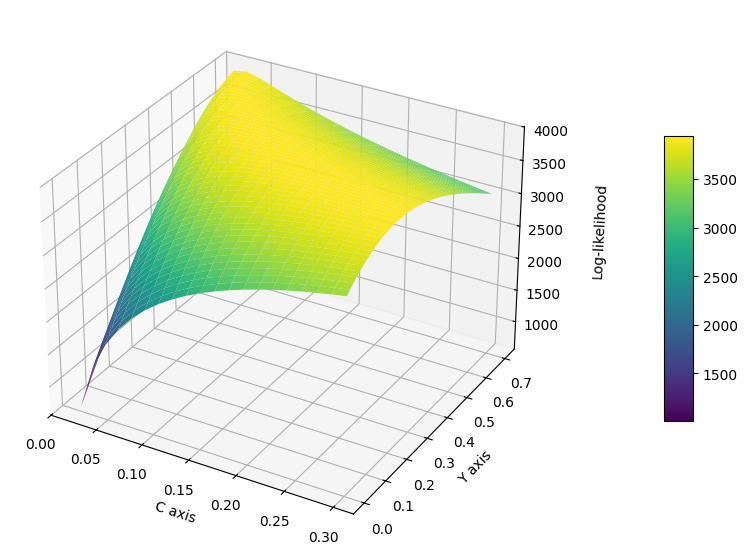

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # not strictly needed in newer matplotlib versions

# chatgpt this figure

# Create a grid of X, Y points
x = np.linspace(2.0e-02, 3.0e-01, 20)
y = np.linspace(2.e-03, 7.e-01, 100)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        cgmy = CGMY(data, [x[j], 1.21e+02, 1.11e+02, y[i], 1.00e-06])
        Z[i, j] = cgmy.log_lik()

# Create the figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
#
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add labels
ax.set_xlabel('C axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Log-likelihood', labelpad=15)

ax.zaxis._axinfo['tick']['inward_factor'] = 0  # no inward movement
ax.zaxis._axinfo['tick']['outward_factor'] = 0.1  # increase to push ticks out

# Add a color bar
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.15)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
plt.tight_layout()
#plt.savefig('../figures/lik_surface.pdf')
plt.show()


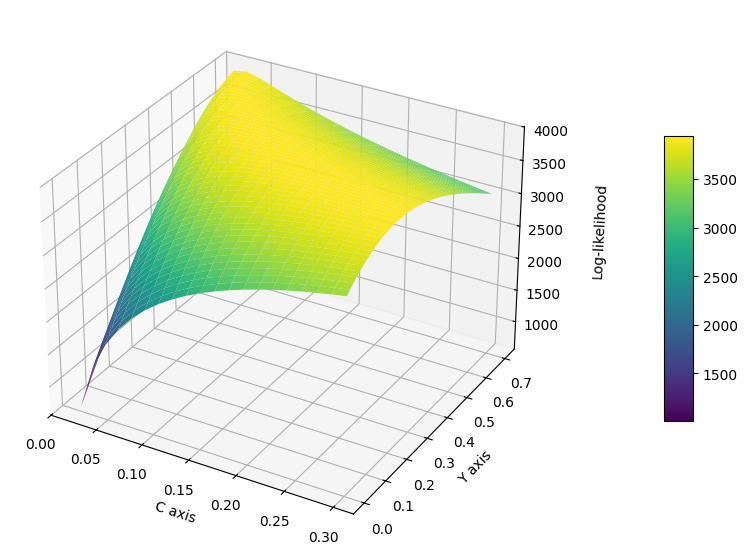

In [52]:
# Create the figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
#
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add labels
ax.set_xlabel('C axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Log-likelihood', labelpad=15)

ax.zaxis._axinfo['tick']['inward_factor'] = 0  # no inward movement
ax.zaxis._axinfo['tick']['outward_factor'] = 0.1  # increase to push ticks out

# Add a color bar
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.15)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
plt.tight_layout()
ax.view_init(elev=30, azim=-60)
#plt.savefig('../figures/lik_surface.pdf')
plt.show()